# Exploratory Data Analysis


### Imports

In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings('ignore')

## <font color='maroon'>EDA</font>

In [3]:
loan_df = pd.read_pickle('./data/Pickle/clean_df_for_eda.pkl')
loan_df.shape

(1087436, 93)

### Loan Amounts for Fully-Paid vs. Charged Off Loans

In [4]:
# Just for visualization purposes, we cast some of the binary variables back to more descriptive strings
loan_df['Loan Outcome'] = loan_df['fully_paid'].map({1:'Fully Paid', 0: 'Charged Off'})


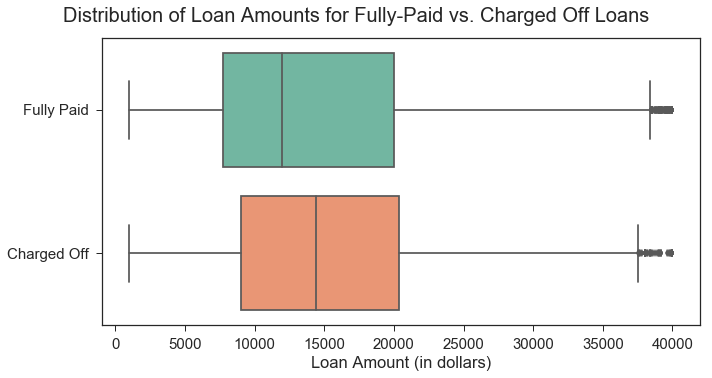

In [5]:
# plotting loan_amnt by fully_paid

plt.subplots(figsize=(10,5))
plt.suptitle("Distribution of Loan Amounts for Fully-Paid vs. Charged Off Loans", x=.5, y=1.04).set_size(20)
sns.boxplot(x="loan_amnt", y="Loan Outcome", data=loan_df, palette='Set2'
           ).set(xlabel='Loan Amount (in dollars)', ylabel='');
plt.tight_layout()

**We see that, on average, loans that end up being fully-paid are smaller (lower loan amount) than those that get charged off.**

### Loan Amount by Grade and Subgrade

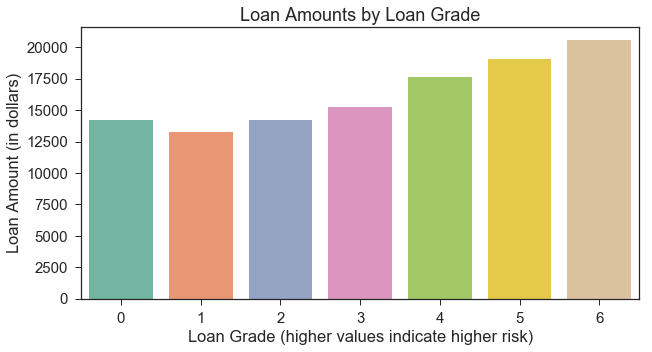

In [6]:
#Loan amount by grade
group = loan_df.groupby("grade").mean()
avg_loan = group['loan_amnt'].reset_index()
xticklabels = avg_loan.index.tolist()

plt.subplots(figsize=(10,5))
plt.title("Loan Amounts by Loan Grade")
sns.barplot(x='grade', y='loan_amnt', data=avg_loan, palette='Set2'
           ).set(xlabel='Loan Grade (higher values indicate higher risk)', ylabel='Loan Amount (in dollars)',
                 xticklabels=xticklabels);


Above, we see that higher loan amounts have less-risky loan grades, on average

Below, we do the same for sub_grade.

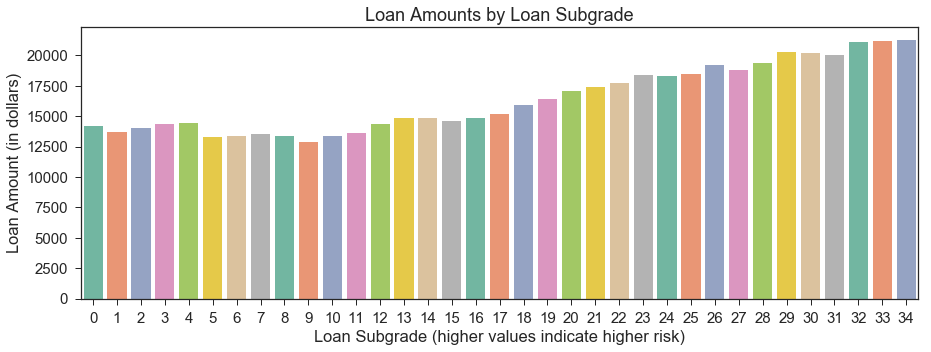

In [7]:
#Loan amount by sub_grade
group = loan_df.groupby("sub_grade").mean()
avg_loan = group['loan_amnt'].reset_index()
plt.subplots(figsize=(15,5))
plt.title("Loan Amounts by Loan Subgrade")
sns.barplot(x='sub_grade', y='loan_amnt', data=avg_loan, palette='Set2'
           ).set(xlabel='Loan Subgrade (higher values indicate higher risk)', ylabel='Loan Amount (in dollars)');

Again, we see that lower (less risky) subgrades tend to be associated with lower loan amounts.

### Number of Loans in Dataset by State

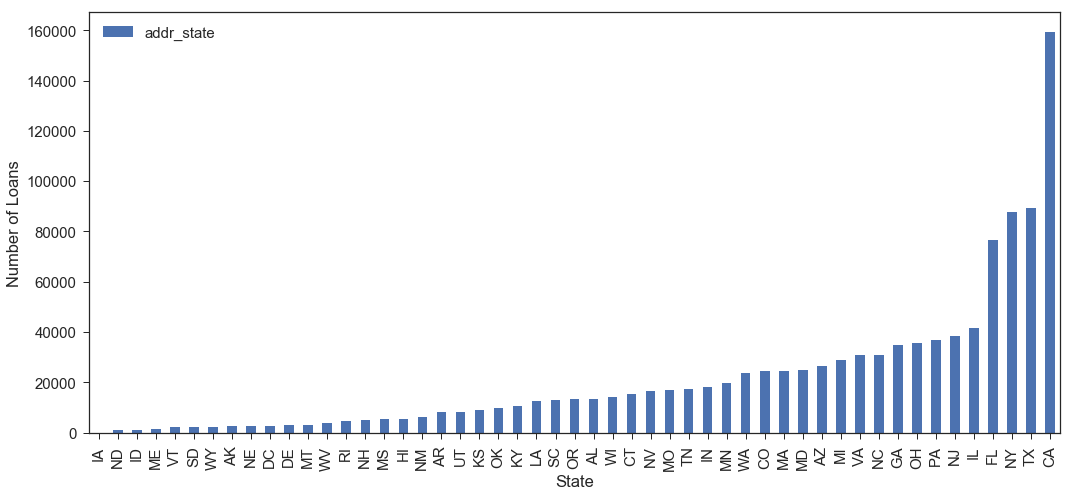

In [8]:
loan_origin=pd.DataFrame(loan_df.groupby('addr_state')['addr_state'].agg('count').sort_values(ascending=True))
loan_origin.plot(kind='bar', figsize=(15,7))
plt.xlabel('State')
plt.ylabel('Number of Loans')
plt.tight_layout()

In [9]:
adress_loan = ['addr_state', 'Loan Outcome']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(loan_df[adress_loan[0]], loan_df[adress_loan[1]]).style.background_gradient(cmap = cm)

Loan Outcome,Charged Off,Fully Paid
addr_state,,
AK,531,2115
AL,3306,10267
AR,1998,6106
AZ,5265,21386
CA,31475,127662
CO,3755,20591
CT,2731,12750
DC,374,2346
DE,622,2400


### Number of Fully Paid vs. Charged Off Loans by Date of Loan Issuance

In [10]:
dates = []
total_loans = []
fully_paid = []
charged_off = []

for year in range(2012,2019):
    for month in range(1,13):
        tmp = loan_df[loan_df['issue_d']==datetime(year,month,1)]
        dates.append(datetime(year,month,1))
        total_loans.append(tmp.shape[0])
        fully_paid.append(tmp[tmp['Loan Outcome']=='Fully Paid'].shape[0])
        charged_off.append(tmp[tmp['Loan Outcome']=='Charged Off'].shape[0])

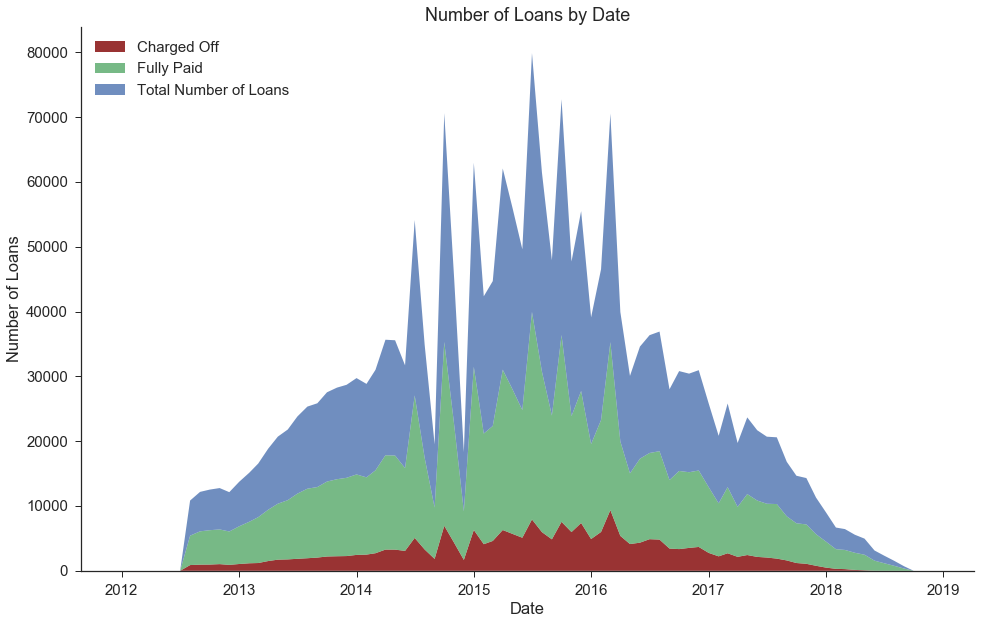

In [11]:
fig, ax = plt.subplots(figsize=(16,10))

plt.stackplot(dates,[charged_off,fully_paid,total_loans], 
              labels=['Charged Off','Fully Paid','Total Number of Loans'], 
              alpha=0.8,colors=['#800000', '#55a868', '#4c72b0'])


ax.set_title('Number of Loans by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Loans')
plt.legend(loc='upper left')

sns.despine();

### Distribution of Annual Income

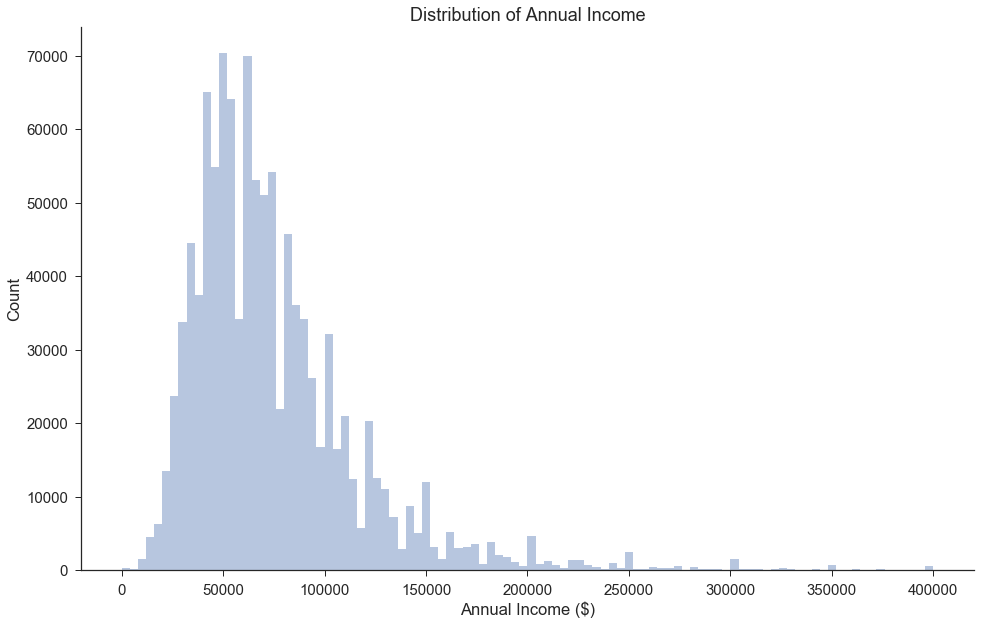

In [12]:
fig, ax = plt.subplots(figsize=(16,10))

sns.distplot(loan_df[loan_df['annual_inc']<=400000]['annual_inc'],bins=100,kde=False,rug=False)

ax.set_title('Distribution of Annual Income')
ax.set_xlabel('Annual Income ($)')
ax.set_ylabel('Count')

sns.despine();

**Majority of loans from lenderclub have applicants with income of around 50k to 70k a year. 
There seems to be loans given to people with very low income including income of 0, however, this maybe due to people who recently lost their jobs, had employment change, or has a cosigner**

### Borrower's Debt-to-Income Ratio vs. Lending Club Interest Rate (by Loan Grade)

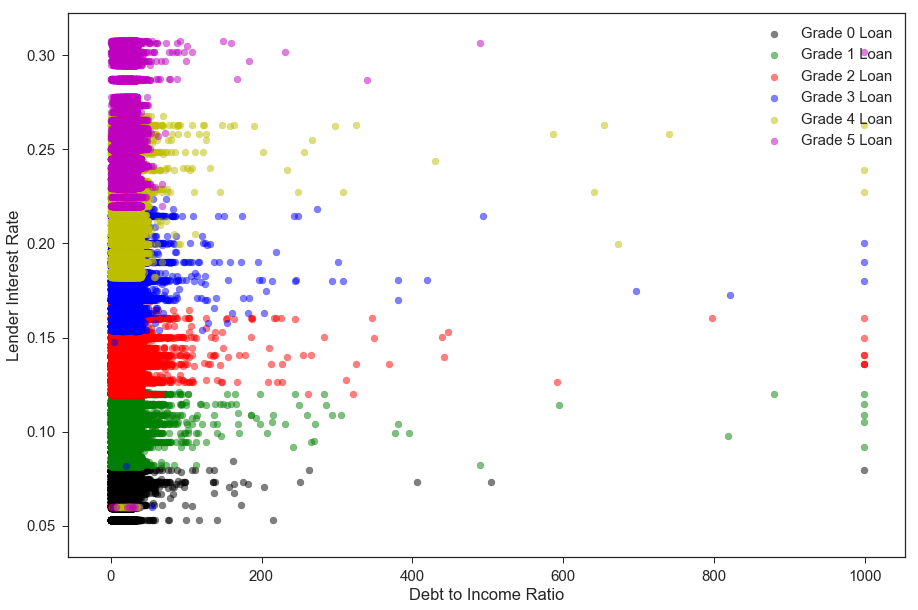

In [13]:
loan_df['interest_rate']=loan_df['int_rate']

#Interest Rates change over time. Let's look at 2018Q2 only.
tmp_df = loan_df[(loan_df['issue_d']>=datetime(2018,4,1))|(loan_df['issue_d']<datetime(2018,7,1))]
#tmp_df['grade'] = tmp_df['grade'].astype('category')

colors=['k','g','r','b','y','m','c']
counter=0
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for grade in np.sort(tmp_df['grade'].unique()[0:-1]):
    ax.scatter(tmp_df[tmp_df['grade']==grade].dti, tmp_df[tmp_df['grade']==grade].interest_rate, alpha=0.5, color=colors[counter], label='Grade '+ str(grade)+ ' Loan')
    counter+=1

ax.set_xlabel('Debt to Income Ratio')
ax.set_ylabel('Lender Interest Rate')
ax.legend(loc='best');

## TODO why does this look different?? see webpage

**Riskier loans tend to have higher interest rates (From A to G represents least to greatest risk)** 

**Riskier applicants also tend to have higher debt to income ratio** 

**These risks should be considered during the loan applicant’s assessment**

### Loan Purpose Distribution

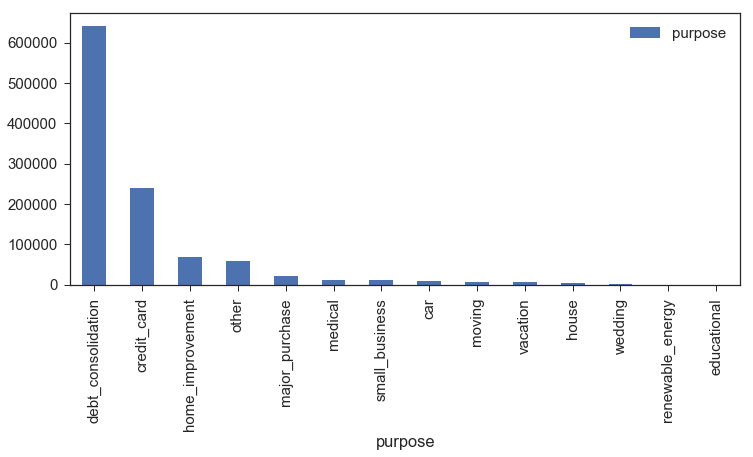

In [14]:
fund_purpose=pd.DataFrame(loan_df.groupby('purpose')['purpose'].agg('count').sort_values(ascending=False))
fund_purpose.plot(kind='bar', figsize=(12,5));

**Majority of loans pertain to paying off debt including consolidating debt and paying of credit_cards**

**Based on this information along with the distribution of income, these may be individuals who are looking get by while paying off their loans without affecting their credit, but do not have the ability to save**

### Removing Excess Columns

The following columns were already re-coded into dummy variables, and we only kept the original columns to facilitate EDA visualizations: `application_type`, `emp_length`, `home_ownership`, `purpose`, `term`, `verification_status`]

We also drop the columns we temporarily generated for visualization purposes: `Loan Outcome` and `interest_rate`


In [15]:
columns = ['application_type', 'emp_length', 'home_ownership', 'purpose', 'term',
           'verification_status', 'Loan Outcome', 'interest_rate']

loan_df = loan_df.drop(columns=columns)

loan_df.shape

(1087436, 87)

In [16]:
loan_df.to_pickle('./data/Pickle/clean_df.pkl')